In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [33]:
from utils.genprodUtils.generators import Generator
from utils.genprodUtils import two_body_decay

class Generator(Generator):
    def valid(self, event):
        self.jet_mass = np.random.lognormal( np.log(10), 0.5, size=(2, len(event)) )
        mask = event.mass > self.jet_mass.sum(axis=0)

        self.jet_mass = self.jet_mass[:,mask]
        return mask
    
    def physics(self, event):
        j1, j2 = two_body_decay(event, *self.jet_mass)
        jets = ak.concatenate([j1[:,None], j2[:,None]], axis=1)
        return dict(jet=jets)

In [43]:

gen_sig = lambda m : Generator(dict(
    pt=lambda n : np.random.lognormal(np.log(100), 1, n),
    eta=lambda n : np.random.uniform(-2.5, 2.5, n),
    phi=lambda n : np.random.uniform(-np.pi, np.pi, n),
    mass=lambda n : np.random.normal(m, 0.1*m, n),
))

masses = [100, 150, 200]
gen_sig = { m : gen_sig(m) for m in masses }

gen_bkg = Generator(dict(
    pt=lambda n : np.random.lognormal(np.log(100), 1, n),
    eta=lambda n : np.random.uniform(-2.5, 2.5, n),
    phi=lambda n : np.random.uniform(-np.pi, np.pi, n),
    mass=lambda n : np.random.lognormal( np.log(100), 1, n),
))


In [44]:
signal = ObjIter([ Tree.from_ak(gen(10000), sample=f'mass={m}', is_signal=True) for m, gen in gen_sig.items() ])
bkg = ObjIter([ Tree.from_ak(gen_bkg(10000), sample='bkg', color='lightgrey') ])

0it [00:00, ?it/s]


[WARNING] unable to open any files with filelist
           []


0it [00:00, ?it/s]


[WARNING] unable to open any files with filelist
           []


0it [00:00, ?it/s]


[WARNING] unable to open any files with filelist
           []


0it [00:00, ?it/s]

[WARNING] unable to open any files with filelist
           []


100%|██████████| 4/4 [00:00<00:00,  8.79it/s]


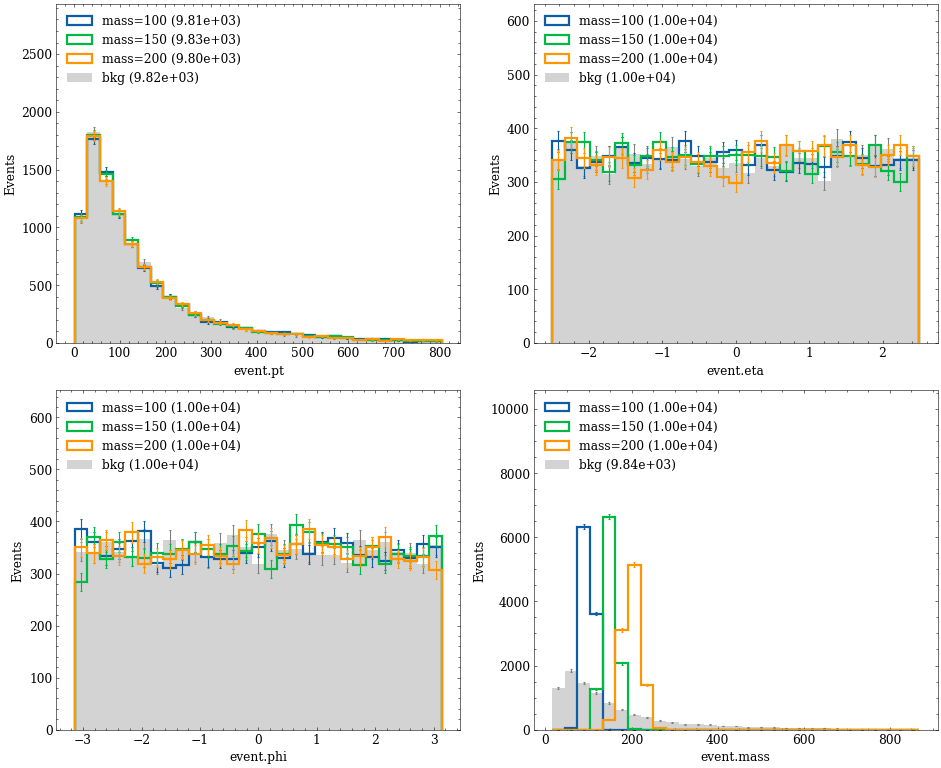

In [45]:
study.quick(
    signal + bkg, 
    varlist=['event.pt','event.eta','event.phi','event.mass'],
    lumi=None,
    legend=True,
)

100%|██████████| 4/4 [00:00<00:00,  6.39it/s]


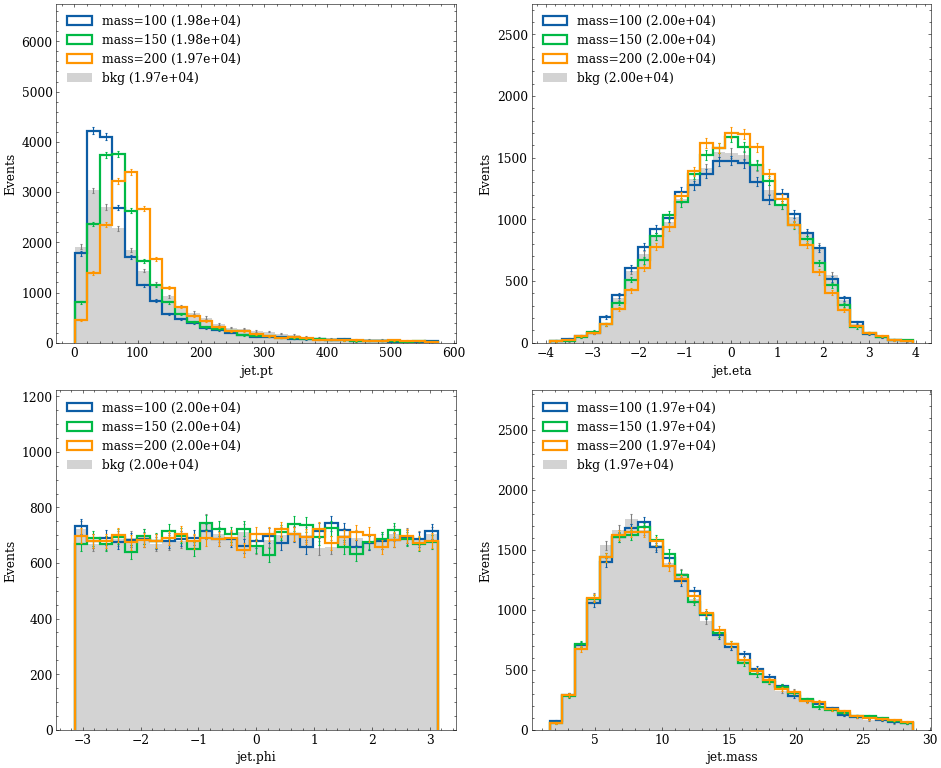

In [46]:
study.quick(
    signal + bkg, 
    varlist=['jet.pt','jet.eta','jet.phi','jet.mass'],
    lumi=None,
    legend=True,
)

In [86]:
import torch

class Hashing(torch.nn.Module):
    def __init__(self, nfts, nbits):
        super().__init__()
        self.nfts = nfts
        self.nbits = nbits
        self.bits = torch.nn.Parameter( torch.arange(nbits).unsqueeze(0), requires_grad=False )
        self.hash = torch.nn.Linear(nfts, nbits)
        self.act = torch.nn.Sigmoid()
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        return self.softmax(self.act(self.hash(x)))

    def predict(self, x):
        return torch.sum(self.bits * self.forward(x), dim=1, keepdims=True) / self.bits.sum()
    

In [87]:
class Classifier(torch.nn.Module):
    def __init__(self, nfts, layers=[], nclasses=2):
        super().__init__()
        self.nfts = nfts
        self.nclasses = nclasses
        self.layers = torch.nn.ModuleList([
            torch.nn.Linear(nfts, layers[0]),
            *[ torch.nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1) ],
            torch.nn.Linear(layers[-1], nclasses),
        ])
        self.act = torch.nn.Sigmoid()
        self.softmax = torch.nn.Softmax(dim=-1)

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.act(layer(x))
        return self.softmax(self.layers[-1](x))

In [91]:
import pytorch_lightning as pl

class ParametericClassifier(pl.LightningModule):
    def __init__(self, nparams, nbits, nfts, layers, nclasses=2, lr=1e-3):
        super().__init__()
        self.named_parameters
        self.nfts = nfts
        self.nbits = nbits
        self.nclasses = nclasses
        self.lr = lr
        self.hashing = Hashing(nparams, nbits)
        self.classifier = Classifier(nfts + 1, layers, nclasses)
        self.loss = torch.nn.CrossEntropyLoss()

    def forward(self, m, x):
        parameter = self.hashing.predict(m)
        x = torch.cat([x, parameter], dim=-1)
        return self.classifier(x)

In [94]:
model = ParametericClassifier(1, 2, 4, [4,4], 2)

In [95]:
model(torch.rand(10,1), torch.rand(10,4))

tensor([[0.7152, 0.2848],
        [0.7149, 0.2851],
        [0.7146, 0.2854],
        [0.7154, 0.2846],
        [0.7153, 0.2847],
        [0.7157, 0.2843],
        [0.7153, 0.2847],
        [0.7147, 0.2853],
        [0.7155, 0.2845],
        [0.7153, 0.2847]], grad_fn=<SoftmaxBackward0>)